# Variational autoencoder (using the VAE class)
PixyzのModel APIに用意されている，VAEクラスを用いて，VanillaなVAEを実装してみましょう．

出典: https://github.com/masa-su/pixyz/blob/master/examples/vae.ipynb

In [30]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter
from tqdm import tqdm

batch_size = 128
epochs = 5
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

%matplotlib inline


In [31]:
root = 'data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda x: x.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=True, transform=transform, download=True),
    shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=False, transform=transform),
    shuffle=False, **kwargs)



0it [00:00, ?it/s]



  0%|          | 0/9912422 [00:00<?, ?it/s]

  0%|          | 16384/9912422 [00:00<02:05, 78813.88it/s]

  0%|          | 40960/9912422 [00:00<01:49, 90277.76it/s]

  1%|          | 90112/9912422 [00:00<01:26, 113027.14it/s]

  1%|▏         | 139264/9912422 [00:01<01:11, 137339.72it/s]

  2%|▏         | 196608/9912422 [00:01<00:58, 165230.29it/s]

  3%|▎         | 253952/9912422 [00:01<00:51, 187925.79it/s]

  3%|▎         | 311296/9912422 [00:01<00:44, 214266.38it/s]

  4%|▍         | 376832/9912422 [00:01<00:38, 244693.36it/s]

  4%|▍         | 442368/9912422 [00:02<00:34, 271734.96it/s]

  5%|▌         | 507904/9912422 [00:02<00:31, 295614.63it/s]

  6%|▌         | 581632/9912422 [00:02<00:28, 323802.28it/s]

  7%|▋         | 663552/9912422 [00:02<00:26, 349489.53it/s]

  7%|▋         | 737280/9912422 [00:02<00:24, 373871.03it/s]

  8%|▊         | 819200/9912422 [00:02<00:21, 432268.24it/s]

  9%|▉         | 909312/9912422 [00:03<00:21, 415636.35it/s]

 10%|█         | 999424/9912

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz





0it [00:00, ?it/s]




  0%|          | 0/28881 [00:00<?, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 90914.05it/s]


32768it [00:00, 59956.45it/s]                           


0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz





  0%|          | 0/1648877 [00:00<?, ?it/s]


  1%|          | 16384/1648877 [00:00<00:21, 74814.79it/s]


  2%|▏         | 40960/1648877 [00:00<00:19, 83156.41it/s]


  5%|▌         | 90112/1648877 [00:01<00:14, 104228.56it/s]


 11%|█▏        | 188416/1648877 [00:01<00:10, 136908.99it/s]


 17%|█▋        | 286720/1648877 [00:01<00:07, 175473.71it/s]


 24%|██▍       | 401408/1648877 [00:01<00:05, 222743.34it/s]


 31%|███▏      | 516096/1648877 [00:01<00:04, 272802.92it/s]


 38%|███▊      | 630784/1648877 [00:02<00:03, 325713.46it/s]


 46%|████▌     | 761856/1648877 [00:02<00:02, 386508.87it/s]


 54%|█████▍    | 892928/1648877 [00:02<00:01, 445146.44it/s]


 62%|██████▏   | 1024000/1648877 [00:02<00:01, 497870.56it/s]


 71%|███████   | 1171456/1648877 [00:02<00:00, 558258.52it/s]


 80%|████████  | 1327104/1648877 [00:02<00:00, 617807.90it/s]


 90%|████████▉ | 1482752/1648877 [00:03<00:00, 730240.38it/s]


100%|█████████▉| 1646592/1648877 [00:03<00:00, 764774.93it/s]


165478

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz





  0%|          | 0/4542 [00:00<?, ?it/s]


8192it [00:00, 23199.25it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!




9920512it [00:28, 2403574.13it/s]                             

### 0) Pixyzのimport
今回は，VAEをModel APIを使って実装します．

VAEの事前分布とエンコーダには正規分布，デコーダにはベルヌーイ分布を利用します．
- 事前分布は平均が0，標準偏差が1の標準正規分布を用います(なのでlocとscaleが定数)

In [32]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE
from pixyz.utils import print_latex

### 1) 分布の定義
Pixyzの分布クラスを継承してネットワークを書いてゆきます．

cond_varには分布で条件付ける確率変数，varには分布の確率変数を指定します．
- つまり，分布の入力はcond_varで条件付けた変数になります

forwardで，分布のパラメータの値をdictで返すようにします．
- ガウス分布の場合，平均(loc)と標準偏差(scale)
- ベルヌーイ分布の場合，確率(probs)

【ポイント！】 nameで分布に名前を与えておくと，あとで見直しやすくなります．

In [33]:
x_dim = 784
z_dim = 64


# inference model q(z|x)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["x"], var=["z"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
    
# prior model p(z)
loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], features_shape=[z_dim], name="p_prior")

#### 分布のインスタンスの作成・deviceの指定

In [34]:
p = Generator().to(device)
q = Inference().to(device)

【ポイント！】 分布をprintするとその分布の中身のネットワークがどうなっているか確認できます．

In [35]:
print(p)
print_latex(p)

Distribution:
  p(x|z)
Network architecture:
  Generator(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )


<IPython.core.display.Math object>

In [36]:
print(q)
print_latex(q)

Distribution:
  q(z|x)
Network architecture:
  Inference(
    name=q, distribution_name=Normal,
    var=['z'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc31): Linear(in_features=512, out_features=64, bias=True)
    (fc32): Linear(in_features=512, out_features=64, bias=True)
  )


<IPython.core.display.Math object>

### 2) 目的関数の設定
今回は，Model APIに用意されているVAEクラスを用いて実装を行ってみましょう．

VAEクラスは，エンコーダからサンプルされた潜在変数zを使ってデコーダで入力を再構成するときの誤差を最小化するようなモデルです．

通常のVAEのLossは
$$
\mathcal { L } _ { \mathrm { VAE } } ( \theta , \phi ) =   \mathbb { E } _ { q _ { \phi } ( z | x ) } \left[ - \log p _ { \theta } ( x | z ) \right] + D _ { \mathrm { KL } } \left( q _ \phi ( z | x ) \| p ( z ) \right)
$$
のように表せますから，正則化項としてエンコーダと事前分布のKLダイバージェンスを指定します．

In [37]:
kl = KullbackLeibler(q, prior)

【ポイント！】 Lossをprintするとそのロスの式を確認できます．

In [38]:
print(kl)
print_latex(kl)

D_{KL} \left[q(z|x)||p_{prior}(z) \right]


<IPython.core.display.Math object>

VAEクラスは，1つ目の引数にエンコーダの分布，2つ目の引数にデコーダの分布をとります．正則化項は，`regularizer`で指定します．

また．学習時のoptimizerもここで指定できます(デフォルトはAdamです)．

VAEクラスがとる引数の詳細は．https://pixyz.readthedocs.io/en/latest/models.html#vae　を見てください．
- ipythonやJupyterを利用している場合は， `VAE?` で引数を確認することもできます．

In [39]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})

【ポイント！】 モデルをprintすると，学習に用いられている分布，Lossの式，optimizerの設定を確認できます．

In [40]:
print(model)

Distributions (for training): 
  q(z|x), p(x|z) 
Loss function: 
  mean \left(D_{KL} \left[q(z|x)||p_{prior}(z) \right] - \mathbb{E}_{q(z|x)} \left[\log p(x|z) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


### 学習してみる
それでは実際に学習してみましょう．

モデルクラスには，`train()`メソッドが用意されており，その引数に入力を与えるだけで，内部でlossを`backward()`して,パラメータを更新(`optimizer.step()`)してくれます．

`test()`メソッドでは，引数として与えられた入力に対するLossを返します．

In [41]:
def train(epoch):
    train_loss = 0
    for x, _ in tqdm(train_loader):
        x = x.to(device)
        loss = model.train({"x": x})
        train_loss += loss
 
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [42]:
def test(epoch):
    test_loss = 0
    for x, _ in test_loader:
        x = x.to(device)
        loss = model.test({"x": x})
        test_loss += loss

    test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [43]:
def plot_reconstrunction(x):
    with torch.no_grad():
        z = q.sample({"x": x}, return_all=False)
        recon_batch = p.sample_mean(z).view(-1, 1, 28, 28)
    
        comparison = torch.cat([x.view(-1, 1, 28, 28), recon_batch]).cpu()
        return comparison
    
def plot_image_from_latent(z_sample):
    with torch.no_grad():
        sample = p.sample_mean({"z": z_sample}).view(-1, 1, 28, 28).cpu()
        return sample

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




  0%|          | 0/469 [00:00<?, ?it/s]


  0%|          | 1/469 [00:00<02:28,  3.16it/s]


  1%|          | 3/469 [00:00<01:53,  4.10it/s]


  1%|          | 5/469 [00:00<01:28,  5.23it/s]


  1%|▏         | 7/469 [00:00<01:10,  6.51it/s]


  2%|▏         | 9/469 [00:00<00:58,  7.86it/s]


  2%|▏         | 11/469 [00:01<00:50,  9.14it/s]


  3%|▎         | 13/469 [00:01<00:45,  9.93it/s]


  3%|▎         | 15/469 [00:01<00:42, 10.61it/s]


  4%|▎         | 17/469 [00:01<00:40, 11.22it/s]


  4%|▍         | 19/469 [00:01<00:37, 12.01it/s]


  4%|▍         | 21/469 [00:01<00:36, 12.25it/s]


  5%|▍         | 23/469 [00:01<00:33, 13.22it/s]


  5%|▌         | 25/469 [00:02<00:32, 13.50it/s]


  6%|▌         | 27/469 [00:02<00:39, 11.06it/s]


  6%|▌         | 29/469 [00:02<00:37, 11.71it/s]


  7%|▋         | 31/469 [00:02<00:35, 12.35it/s]


  7%|▋         | 33/469 [00:02<00:35, 12.39it/s]


  7%|▋         | 35/469 [00:02<00:36, 11.94it/s]


  8%|▊         | 37/469 [00:03<00:37, 11.6

 57%|█████▋    | 269/469 [00:19<00:13, 14.30it/s]


 58%|█████▊    | 271/469 [00:19<00:13, 14.26it/s]


 58%|█████▊    | 273/469 [00:19<00:13, 14.46it/s]


 59%|█████▊    | 275/469 [00:19<00:13, 14.55it/s]


 59%|█████▉    | 277/469 [00:19<00:12, 14.93it/s]


 59%|█████▉    | 279/469 [00:19<00:12, 15.29it/s]


 60%|█████▉    | 281/469 [00:20<00:12, 15.45it/s]


 60%|██████    | 283/469 [00:20<00:11, 15.60it/s]


 61%|██████    | 285/469 [00:20<00:11, 15.66it/s]


 61%|██████    | 287/469 [00:20<00:11, 15.91it/s]


 62%|██████▏   | 289/469 [00:20<00:11, 15.33it/s]


 62%|██████▏   | 291/469 [00:20<00:11, 15.57it/s]


 62%|██████▏   | 293/469 [00:20<00:11, 15.54it/s]


 63%|██████▎   | 295/469 [00:20<00:11, 15.66it/s]


 63%|██████▎   | 297/469 [00:21<00:10, 15.76it/s]


 64%|██████▍   | 299/469 [00:21<00:11, 15.26it/s]


 64%|██████▍   | 301/469 [00:21<00:11, 14.95it/s]


 65%|██████▍   | 303/469 [00:21<00:10, 15.26it/s]


 65%|██████▌   | 305/469 [00:21<00:10, 15.27it/s]


 65%|██████▌

Epoch: 1 Train loss: 177.2327
Test loss: 140.6011
再構成:


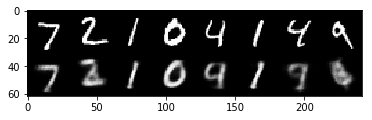

事前分布からのサンプル:


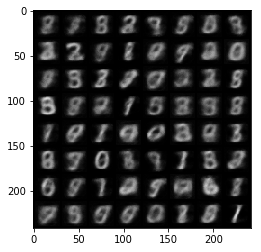




  0%|          | 0/469 [00:00<?, ?it/s]


  0%|          | 1/469 [00:00<01:21,  5.75it/s]


  1%|          | 3/469 [00:00<01:06,  7.00it/s]


  1%|          | 5/469 [00:00<00:55,  8.38it/s]


  1%|▏         | 7/469 [00:00<00:47,  9.80it/s]


  2%|▏         | 9/469 [00:00<00:41, 11.11it/s]


  2%|▏         | 11/469 [00:00<00:38, 11.95it/s]


  3%|▎         | 13/469 [00:00<00:36, 12.59it/s]


  3%|▎         | 15/469 [00:01<00:34, 13.03it/s]


  4%|▎         | 17/469 [00:01<00:33, 13.59it/s]


  4%|▍         | 19/469 [00:01<00:31, 14.15it/s]


  4%|▍         | 21/469 [00:01<00:30, 14.65it/s]


  5%|▍         | 23/469 [00:01<00:29, 14.96it/s]


  5%|▌         | 25/469 [00:01<00:29, 15.18it/s]


  6%|▌         | 27/469 [00:01<00:30, 14.72it/s]


  6%|▌         | 29/469 [00:02<00:29, 14.86it/s]


  7%|▋         | 31/469 [00:02<00:29, 14.79it/s]


  7%|▋         | 33/469 [00:02<00:29, 14.86it/s]


  7%|▋         | 35/469 [00:02<00:29, 14.75it/s]


  8%|▊         | 37/469 [00:02<00:31, 13.7

 57%|█████▋    | 269/469 [00:19<00:16, 11.79it/s]


 58%|█████▊    | 271/469 [00:19<00:16, 11.71it/s]


 58%|█████▊    | 273/469 [00:19<00:17, 11.44it/s]


 59%|█████▊    | 275/469 [00:19<00:17, 11.04it/s]


 59%|█████▉    | 277/469 [00:20<00:16, 11.36it/s]


 59%|█████▉    | 279/469 [00:20<00:16, 11.80it/s]


 60%|█████▉    | 281/469 [00:20<00:15, 11.93it/s]


 60%|██████    | 283/469 [00:20<00:15, 12.17it/s]


 61%|██████    | 285/469 [00:20<00:14, 12.65it/s]


 61%|██████    | 287/469 [00:20<00:14, 12.30it/s]


 62%|██████▏   | 289/469 [00:21<00:14, 12.51it/s]


 62%|██████▏   | 291/469 [00:21<00:13, 12.77it/s]


 62%|██████▏   | 293/469 [00:21<00:13, 12.65it/s]


 63%|██████▎   | 295/469 [00:21<00:13, 12.76it/s]


 63%|██████▎   | 297/469 [00:21<00:13, 12.79it/s]


 64%|██████▍   | 299/469 [00:21<00:13, 12.78it/s]


 64%|██████▍   | 301/469 [00:22<00:13, 12.88it/s]


 65%|██████▍   | 303/469 [00:22<00:12, 12.88it/s]


 65%|██████▌   | 305/469 [00:22<00:13, 12.56it/s]


 65%|██████▌

Epoch: 2 Train loss: 128.6187
Test loss: 121.4329
再構成:


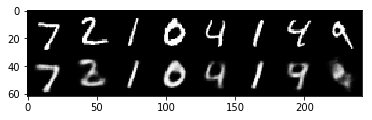

事前分布からのサンプル:


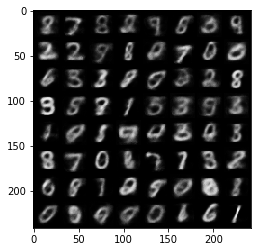




  0%|          | 0/469 [00:00<?, ?it/s]


  0%|          | 1/469 [00:00<01:26,  5.40it/s]


  1%|          | 3/469 [00:00<01:11,  6.51it/s]


  1%|          | 5/469 [00:00<01:00,  7.68it/s]


  1%|▏         | 7/469 [00:00<00:52,  8.73it/s]


  2%|▏         | 9/469 [00:00<00:47,  9.67it/s]


  2%|▏         | 11/469 [00:00<00:43, 10.59it/s]


  3%|▎         | 13/469 [00:01<00:40, 11.21it/s]


  3%|▎         | 15/469 [00:01<00:39, 11.46it/s]


  4%|▎         | 17/469 [00:01<00:38, 11.77it/s]


  4%|▍         | 19/469 [00:01<00:37, 12.05it/s]


  4%|▍         | 21/469 [00:01<00:36, 12.37it/s]


  5%|▍         | 23/469 [00:01<00:35, 12.66it/s]


  5%|▌         | 25/469 [00:02<00:34, 12.94it/s]


  6%|▌         | 27/469 [00:02<00:34, 12.88it/s]


  6%|▌         | 29/469 [00:02<00:33, 13.02it/s]


  7%|▋         | 31/469 [00:02<00:33, 13.12it/s]


  7%|▋         | 33/469 [00:02<00:33, 13.11it/s]


  7%|▋         | 35/469 [00:02<00:32, 13.30it/s]


  8%|▊         | 37/469 [00:02<00:32, 13.1

 57%|█████▋    | 269/469 [00:21<00:15, 12.56it/s]


 58%|█████▊    | 271/469 [00:21<00:15, 12.71it/s]


 58%|█████▊    | 273/469 [00:21<00:15, 12.95it/s]


 59%|█████▊    | 275/469 [00:21<00:14, 13.13it/s]


 59%|█████▉    | 277/469 [00:21<00:14, 13.03it/s]


 59%|█████▉    | 279/469 [00:22<00:14, 13.00it/s]


 60%|█████▉    | 281/469 [00:22<00:14, 13.20it/s]


 60%|██████    | 283/469 [00:22<00:14, 12.92it/s]


 61%|██████    | 285/469 [00:22<00:14, 13.00it/s]


 61%|██████    | 287/469 [00:22<00:13, 13.17it/s]


 62%|██████▏   | 289/469 [00:22<00:14, 12.44it/s]


 62%|██████▏   | 291/469 [00:23<00:13, 12.80it/s]


 62%|██████▏   | 293/469 [00:23<00:13, 12.83it/s]


 63%|██████▎   | 295/469 [00:23<00:13, 12.95it/s]


 63%|██████▎   | 297/469 [00:23<00:13, 13.21it/s]


 64%|██████▍   | 299/469 [00:23<00:12, 13.18it/s]


 64%|██████▍   | 301/469 [00:23<00:12, 13.48it/s]


 65%|██████▍   | 303/469 [00:23<00:12, 13.10it/s]


 65%|██████▌   | 305/469 [00:24<00:12, 12.92it/s]


 65%|██████▌

Epoch: 3 Train loss: 117.5878
Test loss: 115.1668
再構成:


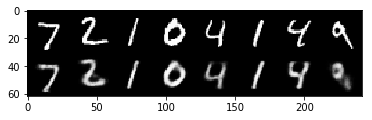

事前分布からのサンプル:


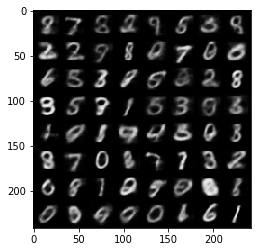




  0%|          | 0/469 [00:00<?, ?it/s]


  0%|          | 1/469 [00:00<01:35,  4.90it/s]


  1%|          | 3/469 [00:00<01:17,  6.00it/s]


  1%|          | 5/469 [00:00<01:04,  7.16it/s]


  1%|▏         | 7/469 [00:00<00:56,  8.25it/s]


  2%|▏         | 8/469 [00:00<00:53,  8.61it/s]


  2%|▏         | 10/469 [00:00<00:48,  9.50it/s]


  3%|▎         | 12/469 [00:01<00:46,  9.88it/s]


  3%|▎         | 14/469 [00:01<00:43, 10.51it/s]


  3%|▎         | 16/469 [00:01<00:40, 11.07it/s]


  4%|▍         | 18/469 [00:01<00:41, 10.86it/s]


  4%|▍         | 20/469 [00:01<00:40, 11.19it/s]


  5%|▍         | 22/469 [00:01<00:38, 11.61it/s]


  5%|▌         | 24/469 [00:02<00:37, 11.77it/s]


  6%|▌         | 26/469 [00:02<00:36, 11.99it/s]


  6%|▌         | 28/469 [00:02<00:35, 12.30it/s]


  6%|▋         | 30/469 [00:02<00:34, 12.55it/s]


  7%|▋         | 32/469 [00:02<00:34, 12.81it/s]


  7%|▋         | 34/469 [00:02<00:33, 12.94it/s]


  8%|▊         | 36/469 [00:03<00:33, 12.9

 57%|█████▋    | 268/469 [00:21<00:15, 12.91it/s]


 58%|█████▊    | 270/469 [00:21<00:15, 12.63it/s]


 58%|█████▊    | 272/469 [00:21<00:15, 12.69it/s]


 58%|█████▊    | 274/469 [00:21<00:15, 12.68it/s]


 59%|█████▉    | 276/469 [00:21<00:15, 12.81it/s]


 59%|█████▉    | 278/469 [00:22<00:14, 12.91it/s]


 60%|█████▉    | 280/469 [00:22<00:14, 13.18it/s]


 60%|██████    | 282/469 [00:22<00:14, 13.25it/s]


 61%|██████    | 284/469 [00:22<00:13, 13.33it/s]


 61%|██████    | 286/469 [00:22<00:13, 13.16it/s]


 61%|██████▏   | 288/469 [00:22<00:13, 13.14it/s]


 62%|██████▏   | 290/469 [00:22<00:13, 13.34it/s]


 62%|██████▏   | 292/469 [00:23<00:13, 13.20it/s]


 63%|██████▎   | 294/469 [00:23<00:13, 12.81it/s]


 63%|██████▎   | 296/469 [00:23<00:13, 12.90it/s]


 64%|██████▎   | 298/469 [00:23<00:13, 12.86it/s]


 64%|██████▍   | 300/469 [00:23<00:12, 13.01it/s]


 64%|██████▍   | 302/469 [00:23<00:12, 13.05it/s]


 65%|██████▍   | 304/469 [00:24<00:12, 13.11it/s]


 65%|██████▌

 97%|█████████▋| 455/469 [00:40<00:01, 10.77it/s]


 97%|█████████▋| 457/469 [00:40<00:01, 10.86it/s]


 98%|█████████▊| 459/469 [00:40<00:00, 10.24it/s]


 98%|█████████▊| 461/469 [00:40<00:00, 10.74it/s]


 99%|█████████▊| 463/469 [00:40<00:00, 11.21it/s]


 99%|█████████▉| 465/469 [00:41<00:00, 11.03it/s]


100%|█████████▉| 467/469 [00:41<00:00, 11.04it/s]


100%|██████████| 469/469 [00:41<00:00, 10.43it/s]




Epoch: 4 Train loss: 112.5522
Test loss: 111.1402
再構成:


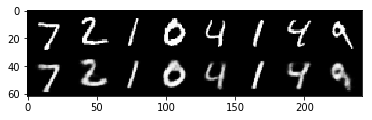

事前分布からのサンプル:


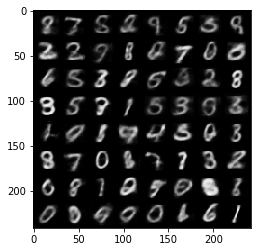




  0%|          | 0/469 [00:00<?, ?it/s]


  0%|          | 1/469 [00:00<01:28,  5.29it/s]


  0%|          | 2/469 [00:00<01:29,  5.22it/s]


  1%|          | 4/469 [00:00<01:18,  5.95it/s]


  1%|▏         | 6/469 [00:00<01:05,  7.12it/s]


  2%|▏         | 8/469 [00:00<00:56,  8.15it/s]


  2%|▏         | 9/469 [00:01<00:53,  8.57it/s]


  2%|▏         | 10/469 [00:01<00:51,  8.94it/s]


  2%|▏         | 11/469 [00:01<00:50,  9.16it/s]


  3%|▎         | 13/469 [00:01<00:45,  9.95it/s]


  3%|▎         | 15/469 [00:01<00:42, 10.73it/s]


  4%|▎         | 17/469 [00:01<00:39, 11.46it/s]


  4%|▍         | 19/469 [00:01<00:43, 10.45it/s]


  4%|▍         | 21/469 [00:02<00:44, 10.00it/s]


  5%|▍         | 23/469 [00:02<00:43, 10.35it/s]


  5%|▌         | 25/469 [00:02<00:44,  9.98it/s]


  6%|▌         | 27/469 [00:02<00:41, 10.74it/s]


  6%|▌         | 29/469 [00:02<00:39, 11.03it/s]


  7%|▋         | 31/469 [00:03<00:40, 10.88it/s]


  7%|▋         | 33/469 [00:03<00:39, 11.17

 46%|████▋     | 217/469 [00:22<00:52,  4.80it/s]


 46%|████▋     | 218/469 [00:22<00:59,  4.18it/s]


 47%|████▋     | 219/469 [00:23<01:08,  3.63it/s]


 47%|████▋     | 220/469 [00:23<01:02,  4.00it/s]


 47%|████▋     | 221/469 [00:23<01:07,  3.70it/s]


 47%|████▋     | 222/469 [00:23<00:57,  4.28it/s]


 48%|████▊     | 223/469 [00:23<00:53,  4.58it/s]


 48%|████▊     | 224/469 [00:24<00:58,  4.16it/s]


 48%|████▊     | 225/469 [00:24<01:11,  3.39it/s]


 48%|████▊     | 226/469 [00:25<01:18,  3.08it/s]


 48%|████▊     | 227/469 [00:25<01:14,  3.26it/s]


 49%|████▊     | 228/469 [00:25<01:21,  2.95it/s]


 49%|████▉     | 229/469 [00:25<01:09,  3.47it/s]


 49%|████▉     | 230/469 [00:26<00:59,  4.04it/s]


 49%|████▉     | 231/469 [00:26<00:57,  4.15it/s]


 49%|████▉     | 232/469 [00:26<01:02,  3.81it/s]


 50%|████▉     | 233/469 [00:26<00:54,  4.34it/s]


 50%|████▉     | 234/469 [00:26<00:52,  4.48it/s]


 50%|█████     | 235/469 [00:27<00:50,  4.63it/s]


 50%|█████  

 94%|█████████▎| 439/469 [00:45<00:03,  8.22it/s]


 94%|█████████▍| 440/469 [00:45<00:03,  7.34it/s]


 94%|█████████▍| 441/469 [00:45<00:03,  7.44it/s]


 94%|█████████▍| 442/469 [00:46<00:03,  7.77it/s]


 94%|█████████▍| 443/469 [00:46<00:03,  8.16it/s]


 95%|█████████▍| 445/469 [00:46<00:02,  9.14it/s]


 95%|█████████▌| 446/469 [00:46<00:02,  7.87it/s]


 95%|█████████▌| 447/469 [00:46<00:02,  7.90it/s]


 96%|█████████▌| 449/469 [00:46<00:02,  9.20it/s]


 96%|█████████▌| 451/469 [00:46<00:01, 10.15it/s]


 97%|█████████▋| 453/469 [00:47<00:01, 11.25it/s]


 97%|█████████▋| 455/469 [00:47<00:01, 11.22it/s]


 97%|█████████▋| 457/469 [00:47<00:01, 11.22it/s]


 98%|█████████▊| 459/469 [00:47<00:00, 11.91it/s]


 98%|█████████▊| 461/469 [00:47<00:00, 10.08it/s]


 99%|█████████▊| 463/469 [00:48<00:00,  9.15it/s]


 99%|█████████▉| 464/469 [00:48<00:00,  8.46it/s]


 99%|█████████▉| 465/469 [00:48<00:00,  8.05it/s]


 99%|█████████▉| 466/469 [00:48<00:00,  7.47it/s]


100%|███████

Epoch: 5 Train loss: 109.3820
Test loss: 108.5267
再構成:


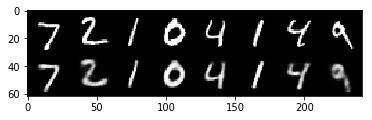

事前分布からのサンプル:


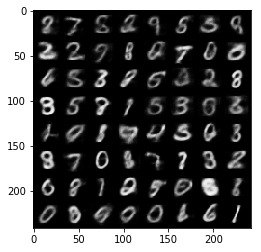

In [44]:
writer = SummaryWriter()

z_sample = 0.5 * torch.randn(64, z_dim).to(device)
_x, _ = iter(test_loader).next()
_x = _x.to(device)

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
    recon = plot_reconstrunction(_x[:8])
    sample = plot_image_from_latent(z_sample)
    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)      
    
    writer.add_image('Image_from_latent', sample[0], epoch)
    writer.add_image('Image_reconstrunction', recon[0], epoch)
    print('再構成:')
    imshow(torchvision.utils.make_grid(recon))
    print('事前分布からのサンプル:')
    imshow(torchvision.utils.make_grid(sample))
writer.close()